# Entrenamiento de Modelos de Machine Learning para predicción Energía Total de Nanopartículas de Oro partir de caracterisitcas superficiales

Debido a que de algunos experimentos es posible solo obtener información superficial de las nanoparticulas, y además son las caracteristicas superficiales las más influyentes en temas de catalisis y por ende aplicaciónes nanotecnologicas se procede a realizar, entrenar y evaluar modelos de machine learing para una sub base de datos superficiales 

In [1]:
import warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning, ignore::FutureWarning')

In [3]:
from utils.path import *
from utils.librerias import * 
from utils.funciones import *
from utils.models import *
from utils.params import * 

Se parte del data set sobre el cual se le realizó la limpieza previa en los notebooks anteriores

In [5]:
data = pd.read_csv(CleanData)

In [6]:
data.head()

,T,N_total,N_bulk,N_surface,Volume,R_min,R_max,R_diff,R_avg,R_std,...,q6q6_S4,q6q6_S5,q6q6_S6,q6q6_S7,q6q6_S8,q6q6_S9,q6q6_S10,q6q6_S11,Formation_E,E_atom
0,273,1599,1014,585,2.710000e-26,15.5898,19.4516,3.8618,17.3706,0.6230,...,33,25,18,18,13,18,1,0,343.4555,-3.695206
1,273,1642,1034,608,2.780000e-26,15.3996,24.1755,8.7760,17.6061,0.9295,...,32,26,26,6,15,12,2,0,384.8166,-3.675642
2,273,4637,3365,1272,7.850000e-26,21.9199,31.0305,9.1106,25.3692,1.0701,...,95,99,117,123,99,116,51,17,800.5040,-3.737366
3,273,7189,5292,1897,1.220000e-25,23.2542,37.8795,14.6253,29.7011,2.3732,...,135,147,188,214,227,227,121,64,1171.7890,-3.747003
4,273,11004,8508,2496,1.860000e-25,27.1200,39.7614,12.6415,34.2831,1.9397,...,154,190,281,308,287,320,156,74,1597.7390,-3.764804


Es posible realizar una separación de la base de datos según el tipo de carcteristicas que describe cada variable. Se agrupan en 3 conjuntos diferentes que capturan diferentes tipos de información sobre las nanopartículas. Los 3 conjuntos de características se denominan Bulk (B), Superficiales (S) y Totales (T). El conjunto de características de bulk solo contendrá características que pertenecen a los átomos interiores, incluidos los números de coordinación, los tipos de red y los parámetros de orden. El segundo conjunto solo contiene características que pertenecen a los átomos exteriores, incluidos los números de coordinación, las orientaciones de las facetas de la superficie y los rangos de curvaturas de la superficie. El conjunto de características totales solo contiene características que involucran medidas globales (como el radio de nanopartículas), promedios y números de coordinación y parámetros de orden calculados sobre todos los átomos en la partícula.

a continuación solo se trabajará con las caracteristicas superficiales. Pero se pueden ver analisis y modelos entrenados en los notebooks extras trabajados y a partir de ellos realizar un trabajo similar al siguiente

In [7]:
bulk = [i for i in data if  any(re.findall( "bulk|BCN_|FCC|HCP|ICOS|DECA" , i)) | (i.startswith('B')) | ("_B" in i)]
super = [i for i in data if  any(re.findall( "surf|_S" , i)) | any(map(i.startswith, ["S_","Curve","SCN_"]))]
totales = [i for i in data if  any(re.findall( "total|Volume|_T|bonds|angle" , i)) |  any(map(i.startswith, ['R',"TCN_"]))]

In [9]:
data_bulk = data[bulk]
data_super = data[super]
data_total = data[totales]

In [11]:
data_total.to_csv(DataTotal, index=False)
data_bulk.to_csv(DataBulk, index=False)
data_super.to_csv(DataSuper, index=False)

In [12]:
data_super.columns

Index(['N_surface', 'S_100', 'S_111', 'S_110', 'S_311', 'Curve_1-10',
       'Curve_11-20', 'Curve_21-30', 'Curve_31-40', 'Curve_41-50',
       'Curve_51-60', 'Curve_61-70', 'Avg_surf', 'SCN_4', 'SCN_5', 'SCN_6',
       'SCN_7', 'SCN_8', 'SCN_9', 'SCN_10', 'SCN_11', 'SCN_12',
       'q6q6_avg_surf', 'q6q6_S0', 'q6q6_S1', 'q6q6_S2', 'q6q6_S3', 'q6q6_S4',
       'q6q6_S5', 'q6q6_S6', 'q6q6_S7', 'q6q6_S8', 'q6q6_S9', 'q6q6_S10',
       'q6q6_S11'],
      dtype='object')

Los parámetros de orden basados en armónicos esféricos y coeficientes de Fourier juegan un papel importante en la investigación de materia condensada en el contexto de sistemas de partículas esféricas o puntuales. Pero se considera que para el presente análisis es suficiente con tomar los valores promedios de dichos parametros de orden. por lo que se eliminan todas las caracterisicas `q6q6_*` y solo quedan `q6q6_avg_surf`

In [14]:
data_super = data_super.loc[:, ~data_super.columns.str.startswith('q6q6_S')]

Se analiza la variable promedio

In [193]:
data_super["q6q6_avg_surf"].describe()

count    3999.000000
mean        4.831352
std         2.850922
min         0.221600
25%         1.621650
50%         5.525000
75%         7.368850
max         8.833300
Name: q6q6_avg_surf, dtype: float64

In [15]:
data_super.head()

,N_surface,S_100,S_111,S_110,S_311,Curve_1-10,Curve_11-20,Curve_21-30,Curve_31-40,Curve_41-50,...,SCN_4,SCN_5,SCN_6,SCN_7,SCN_8,SCN_9,SCN_10,SCN_11,SCN_12,q6q6_avg_surf
0,585,0,81,119,0,105,229,203,47,1,...,0,2,24,81,146,169,91,47,21,2.1026
1,608,0,65,81,1,111,213,204,64,5,...,4,6,33,70,138,172,101,58,14,1.8783
2,1272,4,204,168,24,306,304,443,171,23,...,11,17,66,150,246,386,236,116,34,4.3813
3,1897,8,178,246,46,383,282,729,403,72,...,13,43,138,271,369,490,331,192,37,5.5250
4,2496,18,204,269,57,451,328,966,585,121,...,23,49,230,339,501,575,449,266,51,5.5505


Se analizan en más profundidad las 23 caracteristicas que quedan

In [19]:
prefix = "super"
X=data_super
y=data[["E_atom"]]

In [20]:
feature_names = X.columns.values
label_names = y.columns.values

In [22]:
print('Caracteristicas superficiales: \n', feature_names)
print('Variable objetivo: ', label_names)

Caracteristicas superficiales: 
 ['N_surface' 'S_100' 'S_111' 'S_110' 'S_311' 'Curve_1-10' 'Curve_11-20'
 'Curve_21-30' 'Curve_31-40' 'Curve_41-50' 'Curve_51-60' 'Curve_61-70'
 'Avg_surf' 'SCN_4' 'SCN_5' 'SCN_6' 'SCN_7' 'SCN_8' 'SCN_9' 'SCN_10'
 'SCN_11' 'SCN_12' 'q6q6_avg_surf']
Variable objetivo:  ['E_atom']


<Figure size 360x360 with 0 Axes>

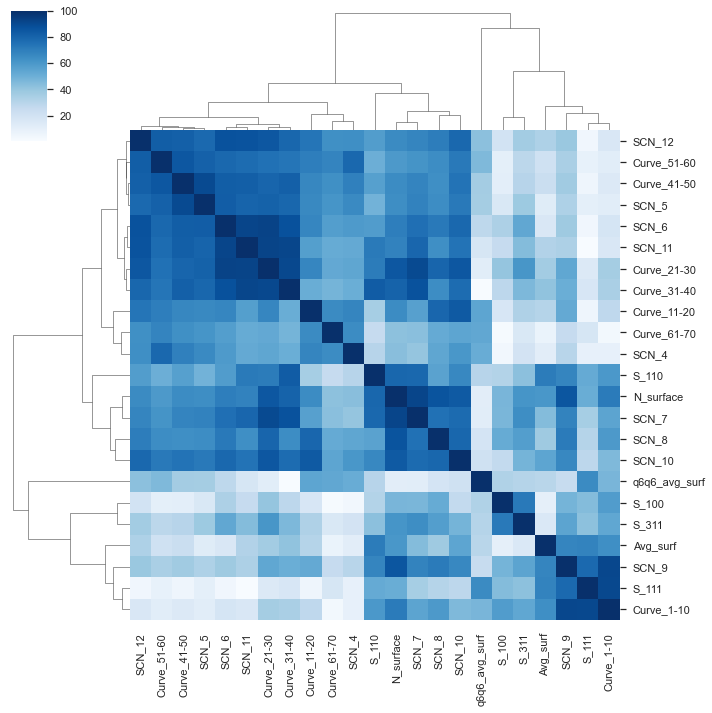

,N_surface,S_100,S_111,S_110,S_311,Curve_1-10,Curve_11-20,Curve_21-30,Curve_31-40,Curve_41-50,...,SCN_4,SCN_5,SCN_6,SCN_7,SCN_8,SCN_9,SCN_10,SCN_11,SCN_12,q6q6_avg_surf
N_surface,100.000000,47.220109,51.107795,79.065288,61.402752,71.704482,64.900578,85.258018,80.403017,64.984617,...,43.263799,64.242551,70.218323,91.897642,86.200302,85.489710,83.744037,68.906141,65.357856,11.514106
S_100,47.220109,100.000000,44.516867,31.453013,72.226168,58.516423,16.793854,39.967246,28.617345,10.883961,...,4.119699,15.757500,33.430871,46.771916,51.742180,47.820266,26.712370,25.907031,19.574515,32.469115
S_111,51.107795,44.516867,100.000000,52.308767,42.159264,90.795520,5.527003,14.420277,16.970260,5.346991,...,9.134538,10.159815,4.536896,35.596867,30.765707,78.243711,28.679141,0.843406,4.511242,65.232050
S_110,79.065288,31.453013,52.308767,100.000000,42.419966,59.749281,35.328818,71.181818,83.055707,56.773105,...,30.539384,48.529503,58.272649,78.628407,55.783772,67.560260,66.532506,71.768494,57.904051,30.653335
S_311,61.402752,72.226168,42.159264,42.419966,100.000000,53.764992,32.621055,61.000045,46.031522,30.425646,...,19.311479,38.043386,53.231710,64.329993,57.474990,54.967253,47.969623,44.274625,36.508939,30.724912
Curve_1-10,71.704482,58.516423,90.795520,59.749281,53.764992,100.000000,27.924296,35.717446,34.434474,14.460642,...,9.115469,11.966853,18.214737,54.799935,59.621150,91.201809,45.772058,16.154313,16.138396,47.170734
Curve_11-20,64.900578,16.793854,5.527003,35.328818,32.621055,27.924296,100.000000,67.217638,50.866851,66.870744,...,67.508247,66.185631,67.176161,56.338997,79.426533,52.738035,83.806381,57.342290,73.535890,54.392427
Curve_21-30,85.258018,39.967246,14.420277,71.181818,61.000045,35.717446,67.217638,100.000000,90.782312,79.661314,...,53.927073,80.700727,92.884586,90.262195,79.702698,53.652659,85.092284,92.510358,85.264123,11.756527
Curve_31-40,80.403017,28.617345,16.970260,83.055707,46.031522,34.434474,50.866851,90.782312,100.000000,81.729732,...,50.686381,78.906126,87.420246,87.084632,64.631629,50.720823,77.096544,91.769565,78.919637,1.168045
Curve_41-50,64.984617,10.883961,5.346991,56.773105,30.425646,14.460642,66.870744,79.661314,81.729732,100.000000,...,69.555209,90.301200,82.208742,68.192198,63.832525,36.993237,74.232124,82.178849,81.720515,36.417817


In [23]:
sns.set()
correlacionados = X.corr(method='spearman').abs().mul(100).astype(float)
plt.figure(figsize=(5,5))
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=50, as_cmap=True)
cg = sns.clustermap(data = correlacionados, cmap='Blues', metric='correlation')
#cg = sns.clustermap(data = correlated, cmap='Blues', metric='correlation', annot =False, fmt='1g')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

plt.savefig('fig/correlation_matrix_{}.png'.format(prefix), dpi=300, bbox_inches='tight')
plt.show()
correlacionados

A continuación se muestra la coordinación que tiene cada atomo de las nanoparticulas.

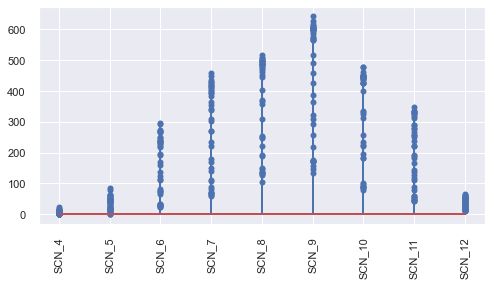

In [25]:
scn = data_super[[i for i in data_super if "SCN_" in i]]
plt.figure(figsize=(8, 4))
cols=[col for col in scn.columns]
x=np.linspace(0, len(cols)-1, len(cols))
for i in range(0,scn.shape[0]//100):
    plt.stem(scn.iloc[i,:])
plt.xticks(x, cols, rotation=90);

Pero además se cuenta con el datos `avg_surf` que es el numero de coordinación promedio de todos los átomos superficiales. POr lo que solo se contará con ese dato y se eliminarán los valores individiuales

In [194]:
data["Avg_surf"].describe()

count    3999.000000
mean        8.471686
std         0.176323
min         7.725900
25%         8.362000
50%         8.498600
75%         8.592050
max         8.923300
Name: Avg_surf, dtype: float64

In [26]:
data_super

,N_surface,S_100,S_111,S_110,S_311,Curve_1-10,Curve_11-20,Curve_21-30,Curve_31-40,Curve_41-50,...,SCN_4,SCN_5,SCN_6,SCN_7,SCN_8,SCN_9,SCN_10,SCN_11,SCN_12,q6q6_avg_surf
0,585,0,81,119,0,105,229,203,47,1,...,0,2,24,81,146,169,91,47,21,2.1026
1,608,0,65,81,1,111,213,204,64,5,...,4,6,33,70,138,172,101,58,14,1.8783
2,1272,4,204,168,24,306,304,443,171,23,...,11,17,66,150,246,386,236,116,34,4.3813
3,1897,8,178,246,46,383,282,729,403,72,...,13,43,138,271,369,490,331,192,37,5.5250
4,2496,18,204,269,57,451,328,966,585,121,...,23,49,230,339,501,575,449,266,51,5.5505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,518,0,7,32,2,37,191,189,77,15,...,3,15,44,101,146,103,73,25,7,0.3707
3995,559,0,8,26,8,52,208,197,76,12,...,5,12,53,105,134,130,78,35,7,0.3309
3996,846,1,13,59,6,89,304,293,121,30,...,5,21,97,156,192,174,117,65,17,0.3664
3997,859,2,13,61,9,96,304,290,131,25,...,4,23,81,159,215,178,111,69,17,0.4284


In [27]:
data_super = data_super.loc[:, ~data_super.columns.str.startswith('SCN_')]

In [29]:
data_super.columns

Index(['N_surface', 'S_100', 'S_111', 'S_110', 'S_311', 'Curve_1-10',
       'Curve_11-20', 'Curve_21-30', 'Curve_31-40', 'Curve_41-50',
       'Curve_51-60', 'Curve_61-70', 'Avg_surf', 'q6q6_avg_surf'],
      dtype='object')

Por ultimo se descartará la información de cuantos átomos con ángulo de curvatura superficial `Curve_XX-XX` entre  $n$ y $n+9$ grados tiene cada particula, ya que se cuenta con los datos del numero de atomos ubicados en las distintas superficies `SXXX` y eso ya comprende la información promedio de la curvatura de las distintas superficies formadas

In [30]:
data_super = data_super.loc[:, ~data_super.columns.str.startswith('Curve_')]

In [203]:
data_super[["S_100",	"S_111", "S_110", "S_311"]].describe()

,S_100,S_111,S_110,S_311
count,3999.000000,3999.000000,3999.000000,3999.000000
mean,22.742936,192.407852,125.447112,25.031008
std,87.343259,268.673774,154.323033,55.251035
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,41.000000,49.000000,4.000000
50%,2.000000,126.000000,79.000000,11.000000
75%,14.000000,238.000000,150.000000,27.000000
max,1554.000000,2661.000000,2414.000000,969.000000


In [205]:
data_super["N_surface"].describe()

count    3999.000000
mean      955.174794
std       721.950028
min       137.000000
25%       437.000000
50%       666.000000
75%      1302.500000
max      3190.000000
Name: N_surface, dtype: float64

In [200]:
data_super

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,585,0,81,119,0,8.7880,2.1026,-5908.6345
1,608,0,65,81,1,8.6513,1.8783,-6035.4034
2,1272,4,204,168,24,8.7303,4.3813,-17330.1660
3,1897,8,178,246,46,8.5778,5.5250,-26937.2010
4,2496,18,204,269,57,8.5533,5.5505,-41427.9010
...,...,...,...,...,...,...,...,...
3994,518,0,7,32,2,8.1950,0.3707,-4230.5430
3995,559,0,8,26,8,8.2719,0.3309,-5346.9589
3996,846,1,13,59,6,8.2790,0.3664,-8218.1252
3997,859,2,13,61,9,8.3132,0.4284,-9876.2899


Finalmente se cuenta con 7 caracteristicas superficiales que son facilmente medibles o calculables para nanoparticuas metalicas.
A continuación se normalizan y se procede con el entrenamiento de los modelos capaces de predecir la energia total que tendrán las nanoparticulas con esas caracteristicas superficiales

En este caso en vez de calcular la energia por átomo, se intentará predecir la energía total de la nanoparticula

In [32]:
df_super = data_super

In [38]:
df_super['target']= pd.read_csv('data/raw/Au_nanoparticle_dataset.csv').iloc[:-1 , :]["Total_E"]

In [222]:
df_super

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,585,0,81,119,0,8.7880,2.1026,-5908.6345
1,608,0,65,81,1,8.6513,1.8783,-6035.4034
2,1272,4,204,168,24,8.7303,4.3813,-17330.1660
3,1897,8,178,246,46,8.5778,5.5250,-26937.2010
4,2496,18,204,269,57,8.5533,5.5505,-41427.9010
...,...,...,...,...,...,...,...,...
3994,518,0,7,32,2,8.1950,0.3707,-4230.5430
3995,559,0,8,26,8,8.2719,0.3309,-5346.9589
3996,846,1,13,59,6,8.2790,0.3664,-8218.1252
3997,859,2,13,61,9,8.3132,0.4284,-9876.2899


In [238]:
df_super.to_csv("data/subdata/processed/data_super_clear.csv",index=False)

### Separación datos de entrenamiento y prueba para los modelos de regresión

se toma un 70% de la base de datos para el entrenamiento y el 30% restante servirán para el testeo

In [116]:
train, test = train_test_split(df_super, test_size=0.3, random_state=1234)

In [117]:
train.shape

(2799, 8)

In [118]:
test.shape

(1200, 8)

In [119]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [120]:
test.head()

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,250,19,24,74,8,8.0680,7.5600,-1801.7178
1,302,0,8,23,1,8.1987,0.5033,-2214.9861
2,648,6,283,56,5,8.5571,5.7870,-6455.2440
3,697,83,359,59,33,8.4634,7.7317,-7981.4638
4,1310,25,220,121,18,8.5542,3.8443,-18210.9970


In [121]:
train.head()

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,444,0,19,39,5,8.3243,0.6126,-3744.7273
1,1930,21,273,259,37,8.6197,4.9990,-24573.6480
2,786,0,616,149,0,8.7163,8.5992,-8229.1297
3,640,6,93,108,18,8.5281,5.4406,-5965.9332
4,323,0,178,65,7,8.4180,7.0124,-2119.9285


### Normalización de los datos

Como se trata de un problema de regresión, es deseable escalar o transformar tanto las variables de entrada como las de destino. 

Se utiliza `StandardScaler` el cual estandariza una característica restando la media y luego escalando de forma que su varianza sea igual a 1. La varianza unitaria significa dividir todos los valores por la desviación estándar.

In [123]:
scaler=StandardScaler()
x_train=train.drop(["target"], axis=1)
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

In [129]:
df_train_scaled=pd.DataFrame(x_train_scaled, columns=x_train.columns)
df_train_scaled['target']=train["target"]

In [130]:
df_train_scaled

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,-0.706392,-0.268788,-0.630082,-0.559923,-0.389196,-0.837574,-1.454536,-3744.7273
1,1.351732,-0.016435,0.305620,0.850922,0.255217,0.842122,0.073031,-24573.6480
2,-0.232719,-0.268788,1.569187,0.145500,-0.489885,1.391406,1.326802,-8229.1297
3,-0.434931,-0.196687,-0.357476,-0.117431,-0.127403,0.321268,0.226818,-5965.9332
4,-0.873979,-0.268788,-0.044347,-0.393187,-0.348920,-0.304779,0.774198,-2119.9285
...,...,...,...,...,...,...,...,...
2794,-0.957079,-0.268788,-0.659553,-0.604814,-0.469748,-1.362976,-1.412328,-1819.9516
2795,1.379432,-0.268788,-0.490095,0.055719,-0.127403,0.076763,-1.492147,-32313.9200
2796,-0.840738,-0.244754,-0.081186,-0.373948,-0.288506,0.055155,1.073973,-2561.6134
2797,0.902989,-0.268788,-0.460624,6.481479,-0.429472,1.673440,1.319141,-19974.8450


In [126]:
with open("utils/pickle/subdata/scaler.pkl", "wb") as file:
  pickle.dump(scaler, file)

## Modelos

A continuación se entrenan los distintos modelos de regressión disponibles en la libreria Python Scikit Learn:
    
    LinearRegression, Ridge, Lasso, ElasticNet, KernelRidge, DecisionTreeRegressor, ExtraTreeRegressor, RandomForestRegressor, KNeighborsRegressor,GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, SVR

Con GridSearchCV se consiguen los mejores hiperparametros, además se utiliza crossvalidation con RepeatedFold

In [127]:
times = {}

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


****************************** 
Entrenando LinearRegression 
 ******************************
	 Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
	 Best Score: 0.9612998423707015
	 Training time: 1.000s
Model Info saved

Modelo LinearRegression Entrenado 
 ******************************
****************************** 
Entrenando Ridge 
 ******************************
	 Best Hyperparameters: {'alpha': 0.5, 'fit_intercept': True, 'max_iter': 100, 'random_state': 0, 'solver': 'svd'}
	 Best Score: 0.9612998974922934
	 Training time: 0.000s
Model Info saved

Modelo Ridge Entrenado 
 ******************************
****************************** 
Entrenando Lasso 
 ******************************
	 Best Hyperparameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'precompute': True, 'selection': 'cyclic', 'tol': 0.01, 'warm_start': True}
	 Best Score: 0.9613061971884392
	 Training time: 3.000s
Model Info saved

Modelo Lasso Entrenado 
 *

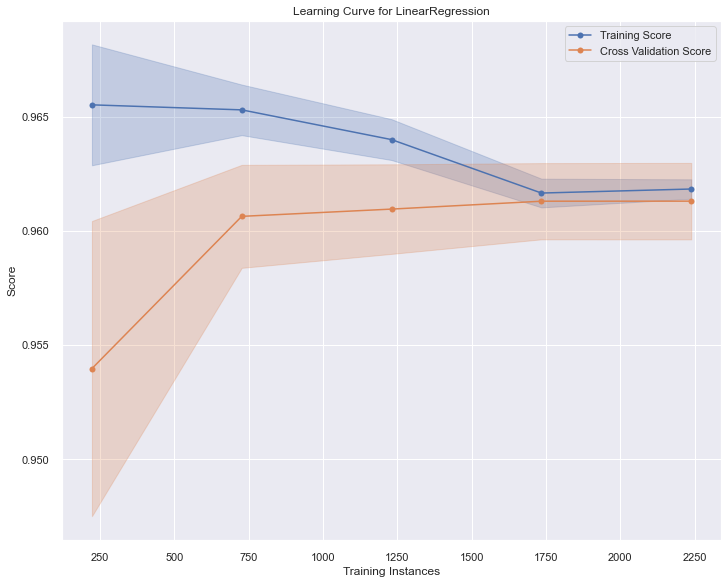

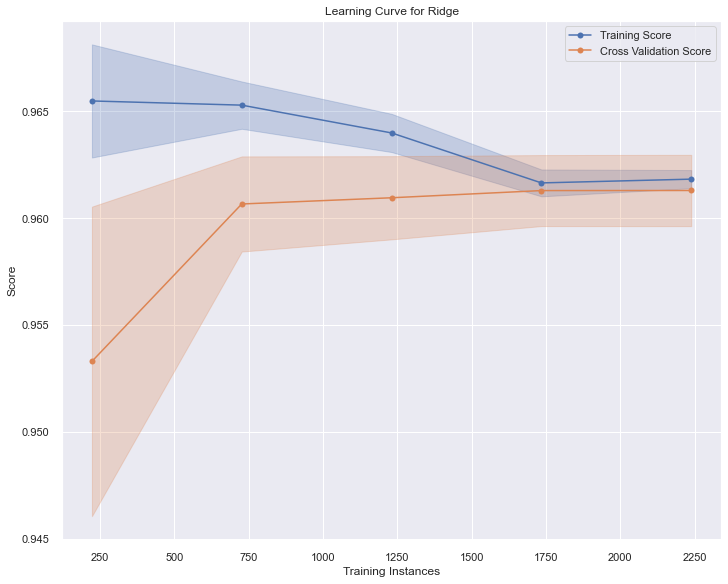

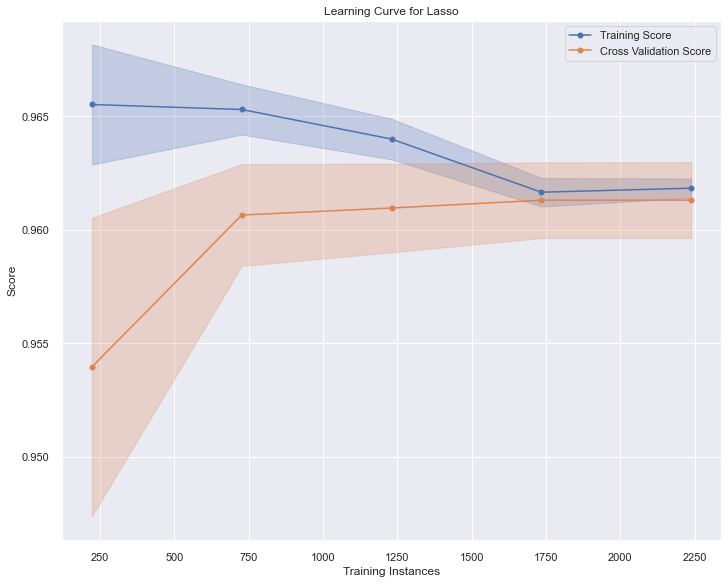

In [131]:
lista=["LinearRegression" , "Ridge", "Lasso"]
for model, modelParams in models.items():
        if model in lista:
            modeling(modelParams[0], modelParams[1], df_train_scaled)

****************************** 
Entrenando ElasticNet 
 ******************************
	 Best Hyperparameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 100, 'precompute': True, 'random_state': None, 'tol': 0.01}
	 Best Score: 0.9612196482666954
	 Training time: 3.000s
Model Info saved

Modelo ElasticNet Entrenado 
 ******************************
****************************** 
Entrenando KernelRidge 
 ******************************
	 Best Hyperparameters: {'alpha': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'polynomial'}
	 Best Score: 0.9895674842103677
	 Training time: 13.000s
Model Info saved

Modelo KernelRidge Entrenado 
 ******************************
****************************** 
Entrenando DecisionTreeRegressor 
 ******************************
	 Best Hyperparameters: {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
	 Best Score: 0.92946227936244

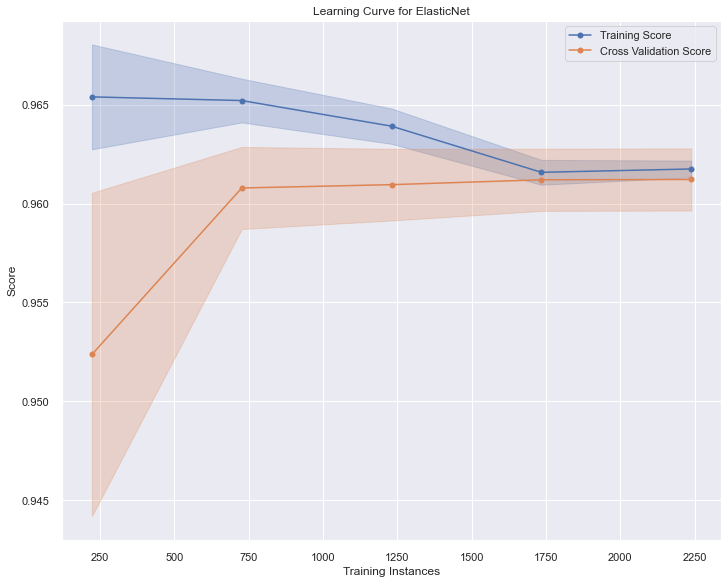

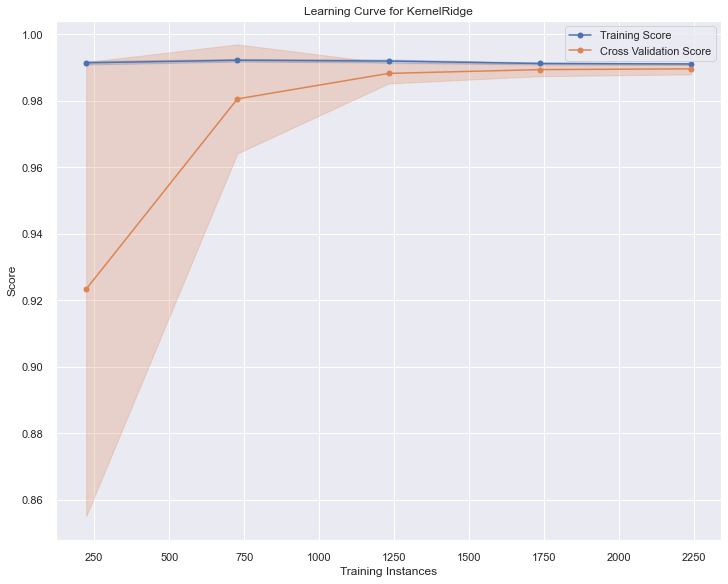

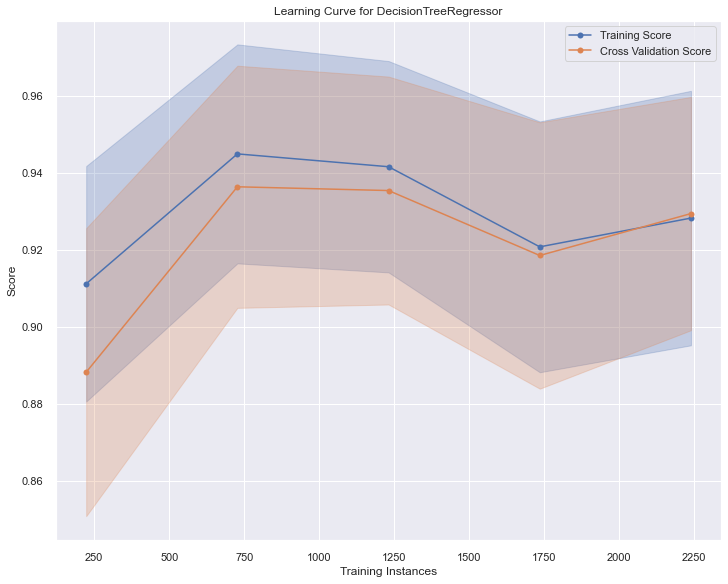

In [132]:
lista=["ElasticNet" , "KernelRidge", "DecisionTreeRegressor"]
for model, modelParams in models.items():
        if model in lista:
            modeling(modelParams[0], modelParams[1], df_train_scaled)

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


****************************** 
Entrenando RandomForestRegressor 
 ******************************
	 Best Hyperparameters: {'bootstrap': True, 'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 500, 'random_state': None}
	 Best Score: 0.9915983596996265
	 Training time: 229.000s
Model Info saved

Modelo RandomForestRegressor Entrenado 
 ******************************
****************************** 
Entrenando KNeighborsRegressor 
 ******************************
	 Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 5}
	 Best Score: 0.9771602137200704
	 Training time: 0.000s
Model Info saved

Modelo KNeighborsRegressor Entrenado 
 ******************************
****************************** 
Entrenando GradientBoostingRegressor 
 ******************************
	 Best Hyperparameters: {'alpha': 0.9, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}
	 Best Score: 0.99361218003096
	 Training time: 69.000s

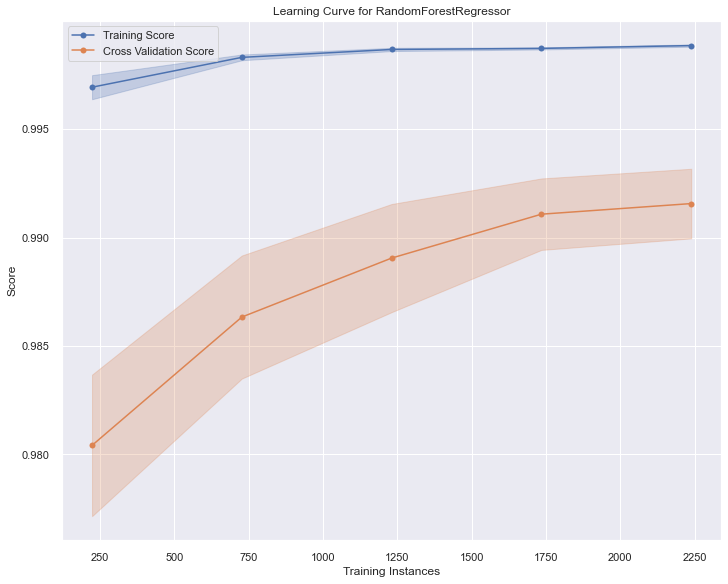

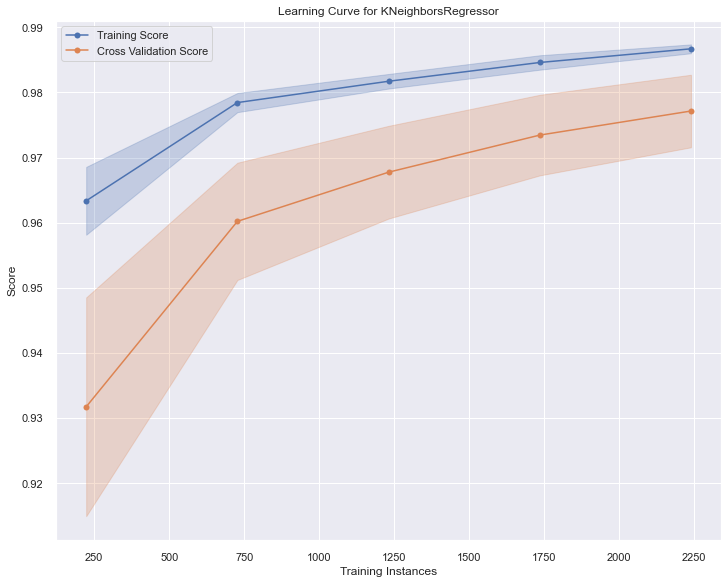

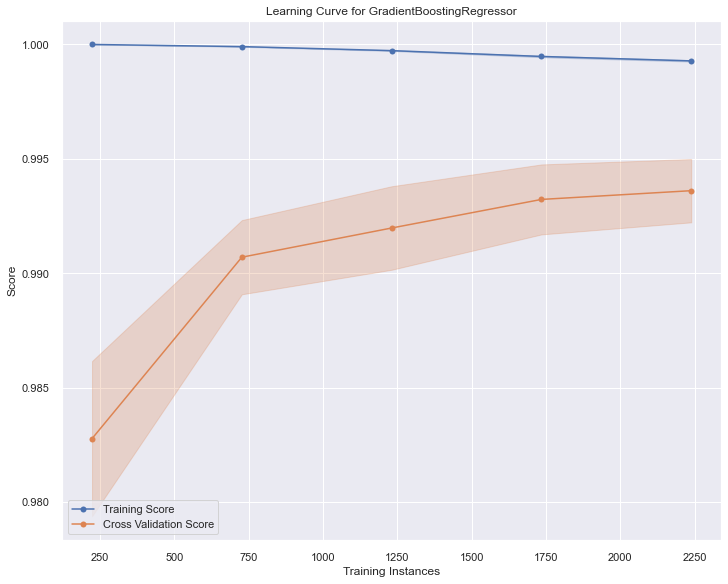

In [133]:
lista=["RandomForestRegressor" , "KNeighborsRegressor", "GradientBoostingRegressor"]
for model, modelParams in models.items():
        if model in lista:
            modeling(modelParams[0], modelParams[1], df_train_scaled)

****************************** 
Entrenando AdaBoostRegressor 
 ******************************
	 Best Hyperparameters: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 100}
	 Best Score: 0.979399747554896
	 Training time: 52.000s
Model Info saved

Modelo AdaBoostRegressor Entrenado 
 ******************************
****************************** 
Entrenando BaggingRegressor 
 ******************************
	 Best Hyperparameters: {'bootstrap': True, 'max_features': 6, 'max_samples': 1.0, 'n_estimators': 100}
	 Best Score: 0.9902668165316785
	 Training time: 21.000s
Model Info saved

Modelo BaggingRegressor Entrenado 
 ******************************


Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


KeyboardInterrupt: 

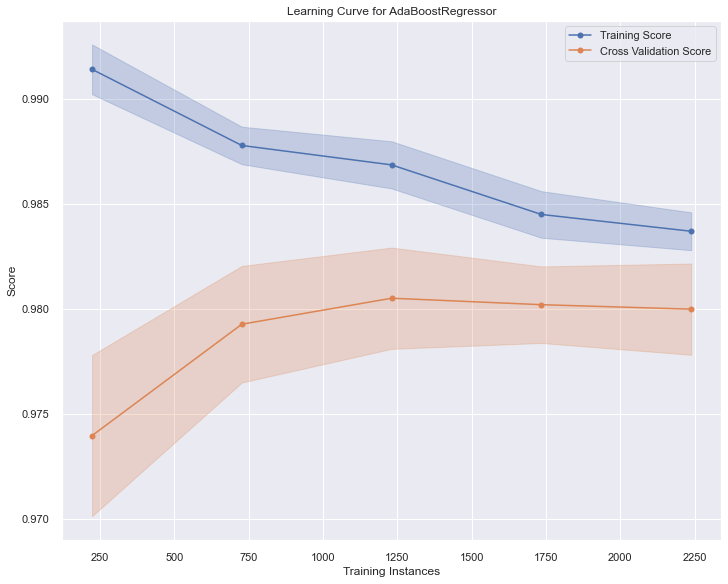

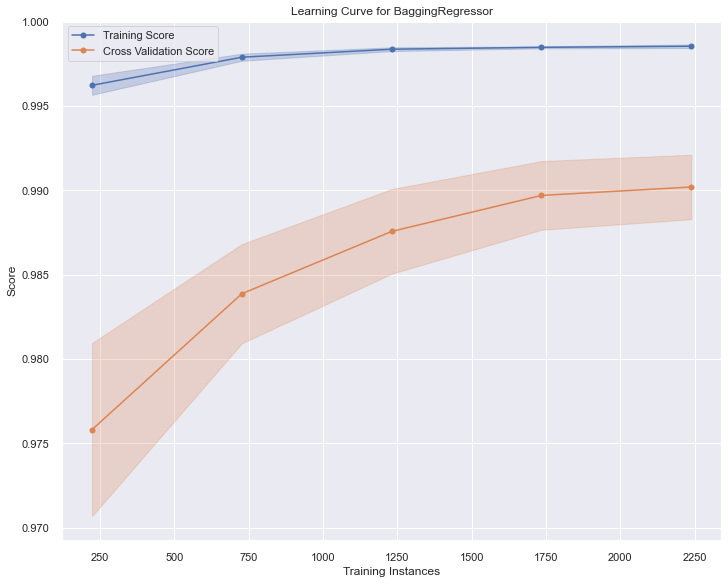

In [134]:
lista=["AdaBoostRegressor" , "BaggingRegressor", "SVR"]
for model, modelParams in models.items():
        if model in lista:
            modeling(modelParams[0], modelParams[1], df_train_scaled)

Hubo un error en el momento de entrenar la regresión con máquinas de vectores de soporte. Pero es un analisis que se realizará en un notebook futuro. Se procede a la seleccion de modelo de entre los entrenados

## Evaluación

In [135]:
test

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,250,19,24,74,8,8.0680,7.5600,-1801.7178
1,302,0,8,23,1,8.1987,0.5033,-2214.9861
2,648,6,283,56,5,8.5571,5.7870,-6455.2440
3,697,83,359,59,33,8.4634,7.7317,-7981.4638
4,1310,25,220,121,18,8.5542,3.8443,-18210.9970
...,...,...,...,...,...,...,...,...
1195,532,0,352,72,28,8.5282,8.3045,-4932.3900
1196,534,21,194,55,11,8.4625,6.0955,-5294.9599
1197,251,1,8,20,5,8.1116,0.5538,-1688.1297
1198,2072,16,275,203,66,8.5396,5.6395,-28360.2240


In [136]:
x_test=test.drop("target", axis=1)

In [137]:
x_test_scaled=scaler.transform(x_test)

Index(['N_surface', 'S_100', 'S_111', 'S_110', 'S_311', 'Avg_surf',
       'q6q6_avg_surf'],
      dtype='object')

In [147]:
df_test_scaled = pd.DataFrame(x_test_scaled, columns=test.columns[:-1])
df_test_scaled["target"] = test["target"]

In [148]:
df_test_scaled

,N_surface,S_100,S_111,S_110,S_311,Avg_surf,q6q6_avg_surf,target
0,-0.975084,-0.040468,-0.611663,-0.335471,-0.328782,-2.294940,0.964900,-1801.7178
1,-0.903064,-0.268788,-0.670605,-0.662530,-0.469748,-1.551757,-1.492600,-2214.9861
2,-0.423851,-0.196687,0.342459,-0.450903,-0.389196,0.486167,0.347452,-6455.2440
3,-0.355985,0.728609,0.622433,-0.431665,0.174665,-0.046627,1.024695,-7981.4638
4,0.493026,0.031633,0.110375,-0.034063,-0.127403,0.469677,-0.329095,-18210.9970
...,...,...,...,...,...,...,...,...
1195,-0.584512,-0.268788,0.596646,-0.348296,0.073976,0.321837,1.224173,-4932.3900
1196,-0.581742,-0.016435,0.014595,-0.457316,-0.268369,-0.051745,0.454887,-5294.9599
1197,-0.973699,-0.256771,-0.670605,-0.681769,-0.389196,-2.047023,-1.475013,-1688.1297
1198,1.548403,-0.076519,0.312988,0.491798,0.839216,0.386659,0.296085,-28360.2240


In [150]:
with open("utils/pickle/subdata/models/LinearRegression_entrenado.pkl","rb") as model:
            modelo=pickle.load(model)

In [154]:
y_pred = modelo.predict(df_test_scaled.drop(columns='target', axis=1))
y_pred

array([  -765.18739076,  -1273.37469752,  -6564.25304146, ...,
         -604.8662904 , -33785.86120071,  -8822.83961527])

In [152]:
pd.DataFrame(y_pred)

,0
0,-765.187391
1,-1273.374698
2,-6564.253041
3,-8166.082966
4,-19228.260704
...,...
1195,-4442.812215
1196,-4841.329345
1197,-604.866290
1198,-33785.861201


In [157]:
df_test_scaled[['target']]

,target
0,-1801.7178
1,-2214.9861
2,-6455.2440
3,-7981.4638
4,-18210.9970
...,...
1195,-4932.3900
1196,-5294.9599
1197,-1688.1297
1198,-28360.2240


In [162]:
dir= 'utils/pickle/subdata/models'
 
for file in os.listdir(dir):
    f = os.path.join(dir, file)
    if os.path.isfile(f):
        with open(f,"rb") as model:
            modelo_entrenado=pickle.load(model)
            score(modelo_entrenado, df_test_scaled, "data/subdata/model_info/model_info.csv" )

****************************** 
Score de 
	 GradientBoostingRegressor() 

	R2 score cluster_38: 0.9945
	MAE score cluster_38: 542.3746
	MSE score cluster_38: 1044424.0138
	RMSE score cluster_38: 1021.9707
	MAPE score cluster_38: 0.0431
..............................
File not exist
Model Info saved
****************************** 
Score de 
	 DecisionTreeRegressor() 

	R2 score cluster_38: 0.9475
	MAE score cluster_38: 1873.896
	MSE score cluster_38: 9946718.1924
	RMSE score cluster_38: 3153.8418
	MAPE score cluster_38: 0.1709
..............................
File exist
****************************** 
Score de 
	 BaggingRegressor() 

	R2 score cluster_38: 0.992
	MAE score cluster_38: 659.2675
	MSE score cluster_38: 1513063.1689
	RMSE score cluster_38: 1230.0663
	MAPE score cluster_38: 0.0527
..............................
File exist
****************************** 
Score de 
	 Lasso() 

	R2 score cluster_38: 0.9625
	MAE score cluster_38: 1789.8026
	MSE score cluster_38: 7107958.7657
	RMSE s

In [163]:
compare_model=pd.read_csv("data/subdata/model_info/model_info.csv")
compare_model

,model_name,hyper_parametros,best_score,R2,MAE,MSE,RMSE,MAPE
0,GradientBoostingRegressor(),"{'alpha': 0.9, 'learning_rate': 0.1, 'loss': '...",0.9936,0.9945,542.3746,1.044424e+06,1021.9707,0.0431
1,DecisionTreeRegressor(),"{'max_depth': 5, 'max_features': 'auto', 'max_...",0.9295,0.9475,1873.8960,9.946718e+06,3153.8418,0.1709
2,BaggingRegressor(),"{'bootstrap': True, 'max_features': 6, 'max_sa...",0.9903,0.9920,659.2675,1.513063e+06,1230.0663,0.0527
3,Lasso(),"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.9613,0.9625,1789.8026,7.107959e+06,2666.0755,0.2881
4,LinearRegression(),"{'copy_X': True, 'fit_intercept': True}",0.9613,0.9625,1789.1292,7.103741e+06,2665.2845,0.2879
5,RandomForestRegressor(),"{'bootstrap': True, 'max_depth': 100, 'min_sam...",0.9916,0.9933,568.4432,1.265528e+06,1124.9571,0.0406
6,KNeighborsRegressor(),"{'algorithm': 'auto', 'leaf_size': 2, 'n_neigh...",0.9772,0.9835,936.0581,3.116923e+06,1765.4811,0.0877
7,AdaBoostRegressor(),"{'learning_rate': 1.0, 'loss': 'square', 'n_es...",0.9794,0.9800,1426.5925,3.785635e+06,1945.6709,0.2609
8,Ridge(),"{'alpha': 0.5, 'fit_intercept': True, 'max_ite...",0.9613,0.9625,1788.8466,7.103802e+06,2665.2958,0.2878
9,ElasticNet(),"{'alpha': 0.01, 'copy_X': True, 'fit_intercept...",0.9612,0.9624,1782.6515,7.121682e+06,2668.6480,0.2836


In [164]:
compare_model.sort_values(" RMSE")

,model_name,hyper_parametros,best_score,R2,MAE,MSE,RMSE,MAPE
0,GradientBoostingRegressor(),"{'alpha': 0.9, 'learning_rate': 0.1, 'loss': '...",0.9936,0.9945,542.3746,1.044424e+06,1021.9707,0.0431
5,RandomForestRegressor(),"{'bootstrap': True, 'max_depth': 100, 'min_sam...",0.9916,0.9933,568.4432,1.265528e+06,1124.9571,0.0406
2,BaggingRegressor(),"{'bootstrap': True, 'max_features': 6, 'max_sa...",0.9903,0.9920,659.2675,1.513063e+06,1230.0663,0.0527
10,KernelRidge(),"{'alpha': 0.1, 'degree': 2, 'gamma': 0.1, 'ker...",0.9896,0.9895,794.4152,1.993411e+06,1411.8819,0.0786
6,KNeighborsRegressor(),"{'algorithm': 'auto', 'leaf_size': 2, 'n_neigh...",0.9772,0.9835,936.0581,3.116923e+06,1765.4811,0.0877
7,AdaBoostRegressor(),"{'learning_rate': 1.0, 'loss': 'square', 'n_es...",0.9794,0.9800,1426.5925,3.785635e+06,1945.6709,0.2609
4,LinearRegression(),"{'copy_X': True, 'fit_intercept': True}",0.9613,0.9625,1789.1292,7.103741e+06,2665.2845,0.2879
8,Ridge(),"{'alpha': 0.5, 'fit_intercept': True, 'max_ite...",0.9613,0.9625,1788.8466,7.103802e+06,2665.2958,0.2878
3,Lasso(),"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.9613,0.9625,1789.8026,7.107959e+06,2666.0755,0.2881
9,ElasticNet(),"{'alpha': 0.01, 'copy_X': True, 'fit_intercept...",0.9612,0.9624,1782.6515,7.121682e+06,2668.6480,0.2836


In [165]:
times=pd.read_csv("data/subdata/model_info/times.csv")
times

,model_name,time
0,LinearRegression,1
1,LinearRegression,0
2,LinearRegression,0
3,Ridge,0
4,Lasso,2
5,ElasticNet,3
6,KernelRidge,13
7,DecisionTreeRegressor,24
8,LinearRegression,1
9,Ridge,0


Se selecciona el GradientBoostingRegressor ya que fue el mejor comparando el RMSE y el tiempo de entrenamiento y de predicción fue considerablemente mejor frente al siguiente mejor que fue el RandomForestRegressor 

In [166]:
with open("utils/pickle/subdata/models/GradientBoostingRegressor_entrenado.pkl","rb") as model:
        gradientBoostingRegressor_entrenado=pickle.load(model)    

In [167]:
with open("my_models/subdata/GradientBoostingRegressor_entrenado.pkl", "wb") as file:
        pickle.dump(gradientBoostingRegressor_entrenado, file)

In [185]:
model_info = compare_model[compare_model["model_name "]== "GradientBoostingRegressor()"]

In [187]:
model_info

,model_name,hyper_parametros,best_score,R2,MAE,MSE,RMSE,MAPE
0,GradientBoostingRegressor(),"{'alpha': 0.9, 'learning_rate': 0.1, 'loss': '...",0.9936,0.9945,542.3746,1.044424e+06,1021.9707,0.0431


In [186]:
model_info.to_csv("my_models/subdata/GradientBoostingRegressor_info.csv")

prueba de una predicción

In [206]:
sample_json={'nSurface': float(1761), 'avgSurf': float(8),
                'q6q6AvgSurf': float(0.41), 'S100': float(122), 
                 'S111': float(230), 'S110': float(345), 'S311': float(24)}

In [207]:
y = [list(sample_json.values())]

In [208]:
y

[[1761.0, 8.0, 0.41, 122.0, 230.0, 345.0, 24.0]]

In [209]:
scaler_sub = pickle.load(open("utils/pickle/subdata/scaler.pkl", 'rb'))

In [210]:
scaler_sub

StandardScaler()

In [215]:
model_sub= pickle.load(open("my_models/subdata/GradientBoostingRegressor_entrenado.pkl", 'rb'))

In [217]:
y_scaled = scaler_sub.transform(y)

In [259]:
y_scaled

array([[ 1.11766508e+00, -1.72653328e-01, -6.98565501e-01,
        -2.76496249e-02,  4.14183082e+00,  1.91355874e+03,
         6.69014109e+00]])

In [219]:
prediction = model_sub.predict(y_scaled)

In [220]:
prediction

array([-35494.13208028])

Resumen de la evaluación del modelo seleccionado en una función para poder llevarlo a productivización

In [ ]:
df_super_train_GB=pd.read_csv("data/subdata/processed/data_super_clear.csv")
scaler_sub = pickle.load(open("utils/pickle/subdata/scaler.pkl", 'rb'))
x_scaled = scaler_sub.transform(df_super_train_GB.drop("target", axis=1))
model = GradientBoostingRegressor(alpha= 0.9, learning_rate= 0.1, loss = 'squared_error', max_depth =  3, min_samples_split = 2, n_estimators = 500)
model_fit = model.fit(x_scaled, df_super_train_GB["target"])


In [239]:
df_super_train_GB=pd.read_csv("data/subdata/processed/data_super_clear.csv")

In [240]:
scaler_sub = pickle.load(open("utils/pickle/subdata/scaler.pkl", 'rb'))

In [241]:
x_scaled = scaler_sub.transform(df_super_train_GB.drop("target", axis=1))

In [242]:
model_sub= pickle.load(open("my_models/subdata/GradientBoostingRegressor_entrenado.pkl", 'rb'))

In [244]:
model_sub.best_params_

{'alpha': 0.9,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [245]:
model_sub.best_estimator_

GradientBoostingRegressor(n_estimators=500)

In [246]:
model = GradientBoostingRegressor(alpha= 0.9, learning_rate= 0.1, loss = 'squared_error', max_depth =  3, min_samples_split = 2, n_estimators = 500)

In [248]:
model_fit = model.fit(x_scaled, df_super_train_GB["target"])

In [254]:
df_super_train_GB.iloc[0,:]

N_surface         585.0000
S_100               0.0000
S_111              81.0000
S_110             119.0000
S_311               0.0000
Avg_surf            8.7880
q6q6_avg_surf       2.1026
target          -5908.6345
Name: 0, dtype: float64

In [260]:
model.predict(y_scaled)

array([-38278.91868271])

In [265]:
sklearn.__version__

'1.1.1'

In [269]:
model_info = pd.read_csv("my_models/subdata/GradientBoostingRegressor_info.csv")


In [271]:
model_info.columns

Index(['Unnamed: 0', 'model_name ', ' hyper_parametros', ' best_score', ' R2',
       '  MAE', ' MSE', ' RMSE', ' MAPE'],
      dtype='object')

In [283]:
model_info["model_name "].to_string().rstrip("()")

'0    GradientBoostingRegressor'

In [276]:
model_info[" MAPE"]*100

0    4.31
Name:  MAPE, dtype: float64

In [278]:
float('%.1g' % model_info[" RMSE"])

1000.0